# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on the opening of the girga bridge in sohag

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
! pip install scenedetect[opencv]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
! pip install ffmpeg-python

In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

# Replace 'your_video_url' with the actual YouTube video URL
video_url = 'https://www.youtube.com/watch?v=FnkLB2abE_Q&t=19s'
youtube = YouTube(video_url)

# Get the highest resolution stream
video_stream = youtube.streams.get_highest_resolution()

# Download the video
video_stream.download()

'/content/الآن  شاهد  الرئيس السيسي يشهد افتتاح كوبري محور جرجا بسوهاج.mp4'

In [ ]:
import ffmpeg
! scenedetect -i video.mp4 time -s 10s detect-content list-scenes

[PySceneDetect] PySceneDetect 0.6.2
[PySceneDetect] Scene list filename format:
  $VIDEO_NAME-Scenes.csv
[PySceneDetect] Detecting scenes...
Detected: 12 | Progress: 100% 27162/27162 [01:14<00:00, 365.00frames/s]
[PySceneDetect] Processed 27162 frames in 74.6 seconds (average 363.91 FPS).
[PySceneDetect] Detected 13 scenes, average shot length 83.6 seconds.
[PySceneDetect] Writing scene list to CSV file:
  video-Scenes.csv
[PySceneDetect] Scene List:
-----------------------------------------------------------------------
 | Scene # | Start Frame |  Start Time  |  End Frame  |   End Time   |
-----------------------------------------------------------------------
 |      1  |         251 | 00:00:10.000 |        2856 | 00:01:54.240 |
 |      2  |        2857 | 00:01:54.240 |        3513 | 00:02:20.520 |
 |      3  |        3514 | 00:02:20.520 |       16762 | 00:11:10.480 |
 |      4  |       16763 | 00:11:10.480 |       17334 | 00:11:33.360 |
 |      5  |       17335 | 00:11:33.360 |     

In [ ]:
!scenedetect -i video.mp4 save-images


[PySceneDetect] PySceneDetect 0.6.2
[PySceneDetect] Image output format set: JPEG [Quality: 95]
[PySceneDetect] Detecting scenes...
Detected: 11 | Progress: 100% 27412/27412 [01:49<00:00, 249.98frames/s]
[PySceneDetect] Processed 27412 frames in 109.7 seconds (average 249.97 FPS).
[PySceneDetect] Detected 12 scenes, average shot length 91.4 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:02:33.600,00:03:03.040,00:11:33.360,00:12:02.040,00:14:24.000,00:14:42.920,00:15:16.280,00:15:28.520,00:17:34.720,00:17:44.960,00:18:15.080
[PySceneDetect] Generating output images (3 per scene)...
100% 36/36 [00:03<00:00, 11.86images/s]


In [ ]:
!pip install transformers torch matplotlib

In [ ]:
import os
import shutil

source_folder = "/content"
destination_folder = "/content/DATA"

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# List all files in the source folder
files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(destination_folder, file)
    shutil.move(source_path, destination_path)

print("Images moved successfully.")


Images moved successfully.


In [ ]:
import warnings,logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [ ]:
import json

captions = [{"file_name": "video-Scene-001-01.jpg", "text": "President Sisi on his way to Girga bridge"},
{"file_name": "video-Scene-001-03.jpg", "text": "President Sisi and his men witnesses the opening of the Girga Bridge in Sohag"},
{"file_name": "video-Scene-002-02.jpg", "text": "Sisi is witnesses the opening of the Girga Bridge in Sohag"},
{"file_name": "video-Scene-002-03.jpg", "text": "sisi men supervising the camera man "},
{"file_name": "video-Scene-004-01.jpg", "text": "sisi with his men talking and the interviewer is Announcing it"},
{"file_name": "video-Scene-005-01.jpg", "text": "Sisi welcoming someone"},
{"file_name": "video-Scene-005-03.jpg", "text": "Girga Bridge"},
{"file_name": "video-Scene-006-03.jpg", "text": "Road full of Sisi Men"},
{"file_name": "video-Scene-007-03.jpg", "text": "President Sisi on his way to Girga bridge and the interviewer is Announcing it"},
{"file_name": "video-Scene-008-02.jpg", "text": "the interviewer is Announcing some news on the opening of girga bridge"},
{"file_name": "video-Scene-009-02.jpg", "text": "sisi with his men talking"}, ]


# path to the folder containing the images
root = "/content/dataaa/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [ ]:
root = "/content/dataaa/"

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 11
})

Let's check whether the dataset is created correctly:

In [ ]:
dataset[0]["text"]


'President Sisi on his way to Girga bridge'

Let's take a look at one example:

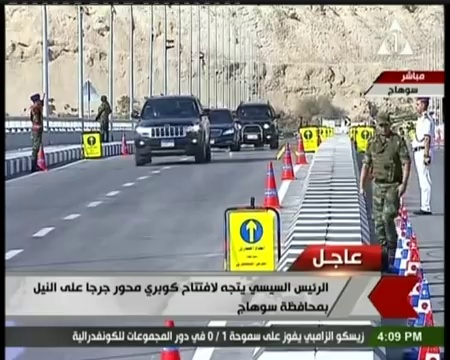

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image)

Let's check its corresponding caption:

In [ ]:
example["text"]

'President Sisi on his way to Girga bridge'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [ ]:
processor.decode(batch["input_ids"][0])

'[CLS] president sisi and his men witnesses the opening of the girga bridge in sohag [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

We can "denormalize" the pixel values to get back an image:

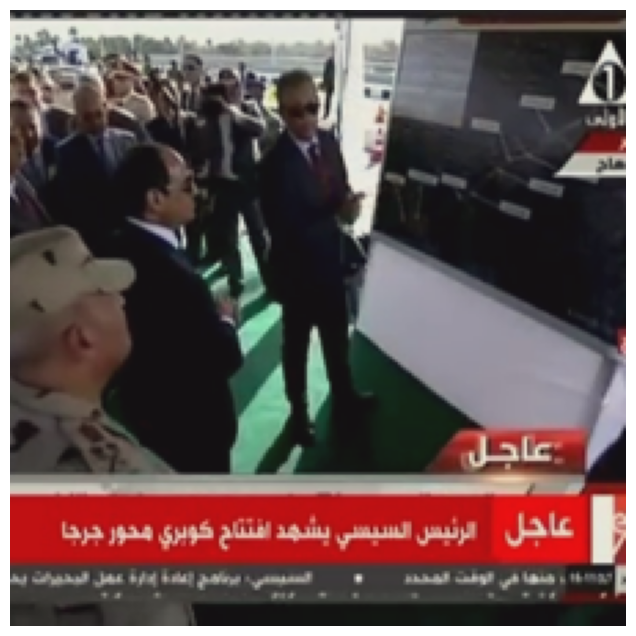

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

# Assuming batch["pixel_values"][0] is your image tensor
unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)

# Create a larger figure
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Display the image using matplotlib
plt.imshow(unnormalized_image)
plt.axis('off')  # Turn off axis
plt.show()


Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0846, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss: 12.295937538146973
Loss: 10.585358619689941
Loss: 10.157780647277832
Loss: 9.826798439025879
Loss: 9.662527084350586
Loss: 9.359518051147461
Epoch: 1
Loss: 9.1561918258667
Loss: 9.042237281799316
Loss: 8.83310604095459
Loss: 8.698395729064941
Loss: 8.582260131835938
Loss: 8.43718433380127
Epoch: 2
Loss: 8.341038703918457
Loss: 8.242876052856445
Loss: 8.067852020263672
Loss: 7.945193767547607
Loss: 7.872809886932373
Loss: 7.722423553466797
Epoch: 3
Loss: 7.695314884185791
Loss: 7.6047749519348145
Loss: 7.454710960388184
Loss: 7.378974437713623
Loss: 7.182522296905518
Loss: 7.105640888214111
Epoch: 4
Loss: 7.049501895904541
Loss: 6.923016548156738
Loss: 6.911430835723877
Loss: 6.673537731170654
Loss: 6.692834377288818
Loss: 6.446333408355713
Epoch: 5
Loss: 6.3438544273376465
Loss: 6.3402419090271
Loss: 6.270719051361084
Loss: 6.116474628448486
Loss: 6.007205009460449
Loss: 5.839650630950928
Epoch: 6
Loss: 5.796413898468018
Loss: 5.6762495040893555
Loss: 5.576540946960449
L

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

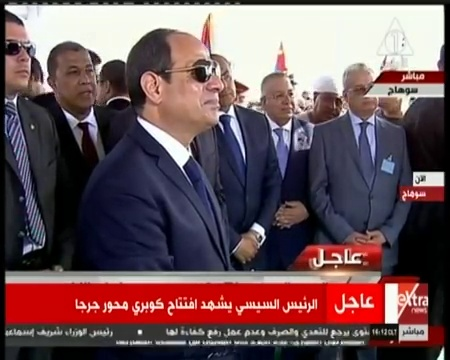

In [ ]:
# load image
example = dataset[2]
image = example["image"]
width, height = image.size
display(image)

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

sisi is witnesses the opening of the girga bridge in sohag


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of video the opening of the girga bridge in sohag